In [1]:
!{sys.executable} -m pip install h5py

/bin/sh: 1: {sys.executable}: not found


In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import datetime
from datetime import date
import holidays
import timeit

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.version.VERSION)

print(tf.keras.__version__)
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Input, Dense, Activation, Reshape
from tensorflow.keras.layers import Concatenate, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint  #use it for deciding hyperparams against val accuracy metric
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json


import pydot_ng 
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")
%matplotlib inline

import pydotplus
#from keras.utils.vis_utils import model_to_dot
#keras.utils.vis_utils.pydot = pydot

1.14.0
2.2.4-tf


In [4]:
#filename = 'data_20.csv'
#Load data from csv
def load_data_and_preprocess(filename):
    df = pd.read_csv(filename)
    df.drop(df[df['one_way'] == True].index, inplace = True, axis = 0)
    df.drop(['id', 'one_way', 'num_stops_outbound_leg', 'num_stops_inbound_leg', 'inserted_timestamp', 'updated_timestamp',\
        'provider', 'cabin_class'], inplace  = True, axis = 1)
    df['timestamp'] = pd.to_datetime(df['download_timestamp'], format = "%Y-%m-%d %H:%M:%S")
    df['booking_date'] = [timestamp.date() for timestamp in df['timestamp']]


    df['start_date'] = pd.to_datetime(df['start_date'], format = "%Y-%m-%d")
    df['start_date'] = [sd.date() for sd in df['start_date']]


    df['end_date'] = pd.to_datetime(df['end_date'], format = "%Y-%m-%d")
    df['end_date'] = [d.date() for d in df['end_date']]

    df['DTD'] = [delta.days for delta in (df['start_date'] - df['booking_date'])]
    df['DTR'] = [delta.days for delta in (df['end_date'] - df['booking_date'])]
    df.drop(['download_timestamp', 'timestamp', 'booking_date'], inplace = True, axis =1)
    df['DoW_D'] = [aday.weekday() for aday in df['start_date']]
    df['DoW_R'] = [aday.weekday() for aday in df['end_date']]

    day_mapping = {6:"Sunday", 0: "Monday", 1:"Tuesday", 2: "Wednesday", 3: "Thursday", 4:"Friday", 5:"Saturday"}

    df['DoW_D'] = df['DoW_D'].map(day_mapping)
    df['DoW_R'] = df['DoW_R'].map(day_mapping)
    India_holidays = holidays.CountryHoliday('IND')
    # or:
    # us_holidays = holidays.US()
    # or:
    # us_holidays = holidays.CountryHoliday('US')
    # or, for specific prov / states:
    # us_holidays = holidays.CountryHoliday('US', prov=None, state='CA')

    #date(2019, 10, 2) in India_holidays  # True

    #df['Holiday Dep'] = ["Y" if (d in India_holidays or d1 in ['Sunday', 'Saturday']) \
    #                    else "N" for d in df['start_date'] for d1 in df['DoWdep']]
    
    
    df['Weekend_D'] = ["Y" if d in ['Sunday', 'Saturday'] else "N" for d in df['DoW_D']]

    df['Indian_Hol_D'] = ["Y" if d in India_holidays else "N" for d in df['start_date']]


    #df['holidaydep'] = ["Y" if (d in ['Sunday', 'Saturday'] or d1 in India_holidays) else "N" \
     #                   for d in df['DoWdep'] for d1 in df['start_date']]

    df['Weekend_R'] = ["Y" if d in ['Sunday', 'Saturday'] else "N" for d in df['DoW_R']]

    df['Indian_Hol_R'] = ["Y" if d in India_holidays else "N" for d in df['end_date']]
    

    df.drop(['start_date', 'end_date'], inplace = True, axis = 1)
    
    return df



In [5]:
#Separating target values

def create_train_val_data(df, fraction):
    x = df.drop('min_price', axis = 1)
    y = (df['min_price'])
    xtrain, xdev, ytrain, ydev = train_test_split(x,y, random_state = 0,test_size =fraction)
    #xval, xtest,yval, ytest = train_test_split(xdev, ydev, random_state =1, test_size = 0.5)
    return xtrain, xdev, ytrain, ydev

In [6]:
#preprocessing all the categorical columns to numerical 
#should take X_train and X_val from create_train_val_data function. 
#We can run the below function separately to get X_test_list

def preproc(X_train, X_val):

    input_list_train = []
    input_list_val = []
    #input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    embed_cols = [i for i in X_train.select_dtypes(include = ['object'])]
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
       # input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    #input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val

In [7]:
def create_model_and_compile(xtrain, optim , loss_function, layers_mat):
    input_models=[]
    output_embeddings=[]

    for categorical_var in xtrain.select_dtypes(include=['object']):
    
        #Name of the categorical variable that will be used in the Keras Embedding layer
        cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
        # Define the embedding_size
        no_of_unique_cat  = xtrain[categorical_var].nunique()
        embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
        #One Embedding Layer for each categorical variable
        input_model = Input(shape=(1,))
        output_model = Embedding(no_of_unique_cat, embedding_size, name= cat_emb_name)(input_model)
        output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
        #Appending all the categorical inputs
        input_models.append(input_model)
  
        #Appending all the embeddings
        output_embeddings.append(output_model)

    numerics = ['float32', 'int32', 'int64', 'float64', 'int16', 'float16']    

    #Other non-categorical data columns (numerical). 
    #I define single another network for the other columns and add them to our models list.
    input_numeric = Input(shape=(len(xtrain.select_dtypes(include=numerics).columns.tolist()),))
    embedding_numeric = Dense(2)(input_numeric) 
    input_models.append(input_numeric)
    output_embeddings.append(embedding_numeric)

    #At the end we concatenate altogther and add other Dense layers
    output = Concatenate()(output_embeddings)
    
    for l in range(len(layers_mat)):
        output = Dense(layers_mat[l]['node'], kernel_initializer = layers_mat[l]['kernel_init'])(output)
        output = Activation(layers_mat[l]['activation'])(output)
        output= Dropout(layers_mat[l]['dropout'])(output)
        
    #output = Dense(1000, kernel_initializer="uniform")(output)
    #output = Activation('relu')(output)
    #output= Dropout(0.4)(output)
    #output = Dense(512, kernel_initializer="uniform")(output)
    #output = Activation('relu')(output)
    #output= Dropout(0.3)(output)
    
    #This is last layer
    output = Dense(1, activation='linear')(output)

    model = Model(inputs=input_models, outputs=output)
    model.compile(loss= loss_function, optimizer= optim, metrics=['mse','mape', 'mae'])
    return model

In [8]:
def plot_my_model(model):
    plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
    #from IPython.display import Image
    #Image(retina=True, filename='model.png')


In [9]:
def show_model_summary(model):
    print(model.summary())

<b>Input params and hyperparameters</b>

In [10]:
# Train data file and hyperparameters
filename = 'train_50.csv'
optimizer = 'Adam'
loss = 'mean_squared_error'

n_epochs = 1000
batch_length = 512
verbose_level = 2

#defining layers and their dimensions
#try another kernel initializer he_uniform
#also try adding learning rate and momentum of gradient descent 
layer_dim = [{'node' : 1000, 'activation': 'relu', 'kernel_init' : 'he_uniform', 'dropout' : 0.4}, \
              {'node' : 512, 'activation': 'relu', 'kernel_init' : 'he_uniform', 'dropout' : 0.3},\
            {'node' : 512, 'activation': 'relu', 'kernel_init' : 'he_uniform', 'dropout' : 0.3}]

layers_mat = layer_dim

<b>Load train data and preprocess</b>

In [11]:
data_df = load_data_and_preprocess(filename)
[xtrain, xdev, ytrain, ydev] = create_train_val_data(data_df, 0.3)
#lets take 15percent of validation as test data




xdev, xtest, ydev, ytest = create_train_val_data(xdev.join(ydev), 0.5 )

[X_train_list, X_val_list] = preproc(xtrain, xdev)

[X_train_list, X_test_list] = preproc(xtrain, xtest)



In [50]:
ytest

26021     7062.00
49978    14899.00
1540      9060.85
26551     7882.00
27361    40305.60
           ...   
28574     6743.00
168       8377.50
17744    22467.70
16403    12430.00
29217     5004.33
Name: min_price, Length: 7336, dtype: float64

<b>Creating model, compile and train</b>

In [17]:
model = create_model_and_compile(xtrain, optimizer , loss, layers_mat)
plot_my_model(model)
show_model_summary(model)
#Checkpoints for best only weights (i.e. overwriting weights as and when we get better performace i.e. Lesser MAE)
filepath="weights.best.4lEANNF.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only = True, mode = 'min')
callbacks_list = [checkpoint]
start = timeit.default_timer()
history = model.fit(X_train_list,ytrain , validation_data = (X_val_list, ydev), \
                        epochs =  n_epochs , batch_size = batch_length, verbose= verbose_level, callbacks = callbacks_list )
stop = timeit.default_timer()
print("Time taken to train on " +  \
          str(n_epochs) + " epochs with a batch_length of " + str(batch_length) + " is " + str((stop-start)/60) + " minutes" )
   

Fontconfig warning: ignoring UTF-8: not a valid region tag

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 1)]          0                                            
________________________________

Epoch 1/1000

Epoch 00001: val_mean_absolute_error improved from inf to 13334.11816, saving model to weights.best.4lEANNF.hdf5
34234/34234 - 8s - loss: 683343988.9326 - mean_squared_error: 683343872.0000 - mean_absolute_percentage_error: 91.8840 - mean_absolute_error: 15339.3340 - val_loss: 607245764.2225 - val_mean_squared_error: 607245760.0000 - val_mean_absolute_percentage_error: 90.5034 - val_mean_absolute_error: 13334.1182
Epoch 2/1000

Epoch 00002: val_mean_absolute_error improved from 13334.11816 to 8358.61914, saving model to weights.best.4lEANNF.hdf5
34234/34234 - 6s - loss: 454382288.5272 - mean_squared_error: 454382304.0000 - mean_absolute_percentage_error: 82.5193 - mean_absolute_error: 11128.7793 - val_loss: 378908121.7186 - val_mean_squared_error: 378908064.0000 - val_mean_absolute_percentage_error: 58.5158 - val_mean_absolute_error: 8358.6191
Epoch 3/1000

Epoch 00003: val_mean_absolute_error improved from 8358.61914 to 6787.85400, saving model to weights.best.4lEANNF.hd


Epoch 00021: val_mean_absolute_error did not improve from 5379.70361
34234/34234 - 6s - loss: 194554716.8915 - mean_squared_error: 194554704.0000 - mean_absolute_percentage_error: 33.9068 - mean_absolute_error: 5573.8042 - val_loss: 232902190.3206 - val_mean_squared_error: 232902192.0000 - val_mean_absolute_percentage_error: 30.9429 - val_mean_absolute_error: 5446.4458
Epoch 22/1000

Epoch 00022: val_mean_absolute_error did not improve from 5379.70361
34234/34234 - 7s - loss: 192207483.5918 - mean_squared_error: 192207472.0000 - mean_absolute_percentage_error: 32.6051 - mean_absolute_error: 5458.1982 - val_loss: 230923660.7328 - val_mean_squared_error: 230923648.0000 - val_mean_absolute_percentage_error: 33.0338 - val_mean_absolute_error: 5409.8555
Epoch 23/1000

Epoch 00023: val_mean_absolute_error improved from 5379.70361 to 5326.63818, saving model to weights.best.4lEANNF.hdf5
34234/34234 - 6s - loss: 190866726.3067 - mean_squared_error: 190866736.0000 - mean_absolute_percentage_er

Epoch 62/1000

Epoch 00062: val_mean_absolute_error did not improve from 4714.88916
34234/34234 - 6s - loss: 126877064.2615 - mean_squared_error: 126877072.0000 - mean_absolute_percentage_error: 27.2993 - mean_absolute_error: 4538.6465 - val_loss: 192758611.9782 - val_mean_squared_error: 192758592.0000 - val_mean_absolute_percentage_error: 27.4787 - val_mean_absolute_error: 4768.5508
Epoch 63/1000

Epoch 00063: val_mean_absolute_error improved from 4714.88916 to 4679.78125, saving model to weights.best.4lEANNF.hdf5
34234/34234 - 6s - loss: 122941534.3434 - mean_squared_error: 122941536.0000 - mean_absolute_percentage_error: 26.8209 - mean_absolute_error: 4491.8296 - val_loss: 196573532.9117 - val_mean_squared_error: 196573520.0000 - val_mean_absolute_percentage_error: 25.9717 - val_mean_absolute_error: 4679.7812
Epoch 64/1000

Epoch 00064: val_mean_absolute_error improved from 4679.78125 to 4661.83203, saving model to weights.best.4lEANNF.hdf5
34234/34234 - 6s - loss: 123509631.2989 - 

Epoch 83/1000

Epoch 00083: val_mean_absolute_error did not improve from 4570.43408
34234/34234 - 6s - loss: 107399956.4111 - mean_squared_error: 107399960.0000 - mean_absolute_percentage_error: 24.7542 - mean_absolute_error: 4209.2993 - val_loss: 222286024.5278 - val_mean_squared_error: 222286032.0000 - val_mean_absolute_percentage_error: 28.2747 - val_mean_absolute_error: 4732.9814
Epoch 84/1000

Epoch 00084: val_mean_absolute_error did not improve from 4570.43408
34234/34234 - 6s - loss: 105985467.2216 - mean_squared_error: 105985464.0000 - mean_absolute_percentage_error: 24.6791 - mean_absolute_error: 4163.5752 - val_loss: 222754080.5671 - val_mean_squared_error: 222754096.0000 - val_mean_absolute_percentage_error: 24.8709 - val_mean_absolute_error: 4699.9175
Epoch 85/1000

Epoch 00085: val_mean_absolute_error did not improve from 4570.43408
34234/34234 - 6s - loss: 104924287.3494 - mean_squared_error: 104924296.0000 - mean_absolute_percentage_error: 24.8571 - mean_absolute_error: 

Epoch 104/1000

Epoch 00104: val_mean_absolute_error improved from 4500.99707 to 4494.04639, saving model to weights.best.4lEANNF.hdf5
34234/34234 - 6s - loss: 99792267.1608 - mean_squared_error: 99792264.0000 - mean_absolute_percentage_error: 23.4445 - mean_absolute_error: 4008.3501 - val_loss: 225340641.1167 - val_mean_squared_error: 225340624.0000 - val_mean_absolute_percentage_error: 25.1946 - val_mean_absolute_error: 4494.0464
Epoch 105/1000

Epoch 00105: val_mean_absolute_error did not improve from 4494.04639
34234/34234 - 6s - loss: 95622995.3611 - mean_squared_error: 95623008.0000 - mean_absolute_percentage_error: 23.8560 - mean_absolute_error: 4034.8318 - val_loss: 235441520.5845 - val_mean_squared_error: 235441536.0000 - val_mean_absolute_percentage_error: 29.2249 - val_mean_absolute_error: 5024.2373
Epoch 106/1000

Epoch 00106: val_mean_absolute_error did not improve from 4494.04639
34234/34234 - 6s - loss: 92136212.4877 - mean_squared_error: 92136208.0000 - mean_absolute_pe

Epoch 125/1000

Epoch 00125: val_mean_absolute_error did not improve from 4346.29004
34234/34234 - 6s - loss: 86286171.7687 - mean_squared_error: 86286160.0000 - mean_absolute_percentage_error: 22.7307 - mean_absolute_error: 3900.6890 - val_loss: 197251985.6663 - val_mean_squared_error: 197252000.0000 - val_mean_absolute_percentage_error: 23.0397 - val_mean_absolute_error: 4419.4116
Epoch 126/1000

Epoch 00126: val_mean_absolute_error did not improve from 4346.29004
34234/34234 - 6s - loss: 84683743.1742 - mean_squared_error: 84683728.0000 - mean_absolute_percentage_error: 22.4929 - mean_absolute_error: 3870.1909 - val_loss: 220960261.0774 - val_mean_squared_error: 220960256.0000 - val_mean_absolute_percentage_error: 24.4668 - val_mean_absolute_error: 4478.1567
Epoch 127/1000

Epoch 00127: val_mean_absolute_error did not improve from 4346.29004
34234/34234 - 6s - loss: 84671504.1028 - mean_squared_error: 84671512.0000 - mean_absolute_percentage_error: 22.5209 - mean_absolute_error: 385

Epoch 146/1000

Epoch 00146: val_mean_absolute_error did not improve from 4271.67139
34234/34234 - 6s - loss: 74622056.9960 - mean_squared_error: 74622072.0000 - mean_absolute_percentage_error: 21.4635 - mean_absolute_error: 3676.1963 - val_loss: 190202008.1091 - val_mean_squared_error: 190202016.0000 - val_mean_absolute_percentage_error: 22.8700 - val_mean_absolute_error: 4329.8667
Epoch 147/1000

Epoch 00147: val_mean_absolute_error did not improve from 4271.67139
34234/34234 - 6s - loss: 75979897.9756 - mean_squared_error: 75979896.0000 - mean_absolute_percentage_error: 22.1474 - mean_absolute_error: 3768.1453 - val_loss: 221040783.2061 - val_mean_squared_error: 221040784.0000 - val_mean_absolute_percentage_error: 25.0088 - val_mean_absolute_error: 4524.5420
Epoch 148/1000

Epoch 00148: val_mean_absolute_error improved from 4271.67139 to 4257.00293, saving model to weights.best.4lEANNF.hdf5
34234/34234 - 6s - loss: 71142448.6782 - mean_squared_error: 71142456.0000 - mean_absolute_pe

Epoch 167/1000

Epoch 00167: val_mean_absolute_error did not improve from 4189.24023
34234/34234 - 6s - loss: 66467093.9637 - mean_squared_error: 66467104.0000 - mean_absolute_percentage_error: 20.7804 - mean_absolute_error: 3542.8499 - val_loss: 204122658.3293 - val_mean_squared_error: 204122640.0000 - val_mean_absolute_percentage_error: 22.0714 - val_mean_absolute_error: 4264.1216
Epoch 168/1000

Epoch 00168: val_mean_absolute_error did not improve from 4189.24023
34234/34234 - 7s - loss: 63881030.1730 - mean_squared_error: 63881020.0000 - mean_absolute_percentage_error: 21.0232 - mean_absolute_error: 3532.0142 - val_loss: 187299286.5256 - val_mean_squared_error: 187299312.0000 - val_mean_absolute_percentage_error: 22.8961 - val_mean_absolute_error: 4197.3892
Epoch 169/1000

Epoch 00169: val_mean_absolute_error improved from 4189.24023 to 4183.88818, saving model to weights.best.4lEANNF.hdf5
34234/34234 - 6s - loss: 59877953.5551 - mean_squared_error: 59877948.0000 - mean_absolute_pe

Epoch 188/1000

Epoch 00188: val_mean_absolute_error did not improve from 4105.68799
34234/34234 - 6s - loss: 55642089.4734 - mean_squared_error: 55642096.0000 - mean_absolute_percentage_error: 20.1865 - mean_absolute_error: 3389.4221 - val_loss: 203102555.8386 - val_mean_squared_error: 203102544.0000 - val_mean_absolute_percentage_error: 21.8596 - val_mean_absolute_error: 4200.3926
Epoch 189/1000

Epoch 00189: val_mean_absolute_error did not improve from 4105.68799
34234/34234 - 6s - loss: 57754707.4614 - mean_squared_error: 57754712.0000 - mean_absolute_percentage_error: 20.4556 - mean_absolute_error: 3435.4023 - val_loss: 212890122.0327 - val_mean_squared_error: 212890128.0000 - val_mean_absolute_percentage_error: 22.3136 - val_mean_absolute_error: 4193.9160
Epoch 190/1000

Epoch 00190: val_mean_absolute_error did not improve from 4105.68799
34234/34234 - 6s - loss: 55945525.9300 - mean_squared_error: 55945528.0000 - mean_absolute_percentage_error: 20.3987 - mean_absolute_error: 344

Epoch 220/1000

Epoch 00220: val_mean_absolute_error did not improve from 4093.14551
34234/34234 - 6s - loss: 46710823.9812 - mean_squared_error: 46710828.0000 - mean_absolute_percentage_error: 19.3056 - mean_absolute_error: 3239.4736 - val_loss: 197098574.3468 - val_mean_squared_error: 197098576.0000 - val_mean_absolute_percentage_error: 20.8372 - val_mean_absolute_error: 4134.5503
Epoch 221/1000

Epoch 00221: val_mean_absolute_error did not improve from 4093.14551
34234/34234 - 7s - loss: 45401500.3244 - mean_squared_error: 45401508.0000 - mean_absolute_percentage_error: 19.2598 - mean_absolute_error: 3243.4084 - val_loss: 211669211.8321 - val_mean_squared_error: 211669200.0000 - val_mean_absolute_percentage_error: 21.7689 - val_mean_absolute_error: 4176.5288
Epoch 222/1000

Epoch 00222: val_mean_absolute_error did not improve from 4093.14551
34234/34234 - 6s - loss: 45420310.1618 - mean_squared_error: 45420316.0000 - mean_absolute_percentage_error: 19.5468 - mean_absolute_error: 325

Epoch 242/1000

Epoch 00242: val_mean_absolute_error did not improve from 4086.81836
34234/34234 - 6s - loss: 38724339.3736 - mean_squared_error: 38724340.0000 - mean_absolute_percentage_error: 18.8292 - mean_absolute_error: 3154.2129 - val_loss: 217703052.2137 - val_mean_squared_error: 217703040.0000 - val_mean_absolute_percentage_error: 20.9552 - val_mean_absolute_error: 4175.0864
Epoch 243/1000

Epoch 00243: val_mean_absolute_error did not improve from 4086.81836
34234/34234 - 6s - loss: 38774303.2793 - mean_squared_error: 38774296.0000 - mean_absolute_percentage_error: 18.9093 - mean_absolute_error: 3141.4448 - val_loss: 214872008.4624 - val_mean_squared_error: 214871984.0000 - val_mean_absolute_percentage_error: 21.0172 - val_mean_absolute_error: 4114.2129
Epoch 244/1000

Epoch 00244: val_mean_absolute_error did not improve from 4086.81836
34234/34234 - 6s - loss: 39091819.1428 - mean_squared_error: 39091824.0000 - mean_absolute_percentage_error: 19.1688 - mean_absolute_error: 318

Epoch 264/1000

Epoch 00264: val_mean_absolute_error did not improve from 4064.84106
34234/34234 - 6s - loss: 35490789.3636 - mean_squared_error: 35490780.0000 - mean_absolute_percentage_error: 18.3438 - mean_absolute_error: 3044.4993 - val_loss: 196790484.2094 - val_mean_squared_error: 196790496.0000 - val_mean_absolute_percentage_error: 20.7124 - val_mean_absolute_error: 4077.1860
Epoch 265/1000

Epoch 00265: val_mean_absolute_error did not improve from 4064.84106
34234/34234 - 6s - loss: 32470945.1149 - mean_squared_error: 32470942.0000 - mean_absolute_percentage_error: 18.3318 - mean_absolute_error: 3018.5935 - val_loss: 199694546.1112 - val_mean_squared_error: 199694560.0000 - val_mean_absolute_percentage_error: 19.9276 - val_mean_absolute_error: 4085.3735
Epoch 266/1000

Epoch 00266: val_mean_absolute_error did not improve from 4064.84106
34234/34234 - 6s - loss: 32023296.6660 - mean_squared_error: 32023290.0000 - mean_absolute_percentage_error: 18.3199 - mean_absolute_error: 302

Epoch 285/1000

Epoch 00285: val_mean_absolute_error did not improve from 4020.65210
34234/34234 - 6s - loss: 32101683.9175 - mean_squared_error: 32101690.0000 - mean_absolute_percentage_error: 18.0553 - mean_absolute_error: 2976.0989 - val_loss: 196808822.3555 - val_mean_squared_error: 196808800.0000 - val_mean_absolute_percentage_error: 20.3685 - val_mean_absolute_error: 4068.1707
Epoch 286/1000

Epoch 00286: val_mean_absolute_error did not improve from 4020.65210
34234/34234 - 6s - loss: 31638995.8274 - mean_squared_error: 31638996.0000 - mean_absolute_percentage_error: 18.1449 - mean_absolute_error: 3015.5198 - val_loss: 212532718.9182 - val_mean_squared_error: 212532736.0000 - val_mean_absolute_percentage_error: 21.0250 - val_mean_absolute_error: 4116.6021
Epoch 287/1000

Epoch 00287: val_mean_absolute_error did not improve from 4020.65210
34234/34234 - 6s - loss: 31801290.3198 - mean_squared_error: 31801292.0000 - mean_absolute_percentage_error: 17.9182 - mean_absolute_error: 294

Epoch 307/1000

Epoch 00307: val_mean_absolute_error did not improve from 3977.86963
34234/34234 - 6s - loss: 30177712.3350 - mean_squared_error: 30177712.0000 - mean_absolute_percentage_error: 17.5245 - mean_absolute_error: 2910.0652 - val_loss: 210840439.1843 - val_mean_squared_error: 210840432.0000 - val_mean_absolute_percentage_error: 19.7957 - val_mean_absolute_error: 4138.2144
Epoch 308/1000

Epoch 00308: val_mean_absolute_error did not improve from 3977.86963
34234/34234 - 6s - loss: 28957064.3421 - mean_squared_error: 28957064.0000 - mean_absolute_percentage_error: 17.4832 - mean_absolute_error: 2906.1609 - val_loss: 205729228.7721 - val_mean_squared_error: 205729232.0000 - val_mean_absolute_percentage_error: 20.3489 - val_mean_absolute_error: 4107.9512
Epoch 309/1000

Epoch 00309: val_mean_absolute_error did not improve from 3977.86963
34234/34234 - 6s - loss: 28155372.8116 - mean_squared_error: 28155374.0000 - mean_absolute_percentage_error: 17.4532 - mean_absolute_error: 286

Epoch 329/1000

Epoch 00329: val_mean_absolute_error did not improve from 3934.05688
34234/34234 - 6s - loss: 29174477.0457 - mean_squared_error: 29174476.0000 - mean_absolute_percentage_error: 17.1950 - mean_absolute_error: 2852.4387 - val_loss: 194466654.6565 - val_mean_squared_error: 194466640.0000 - val_mean_absolute_percentage_error: 20.7568 - val_mean_absolute_error: 4037.5530
Epoch 330/1000

Epoch 00330: val_mean_absolute_error did not improve from 3934.05688
34234/34234 - 6s - loss: 25442371.3956 - mean_squared_error: 25442372.0000 - mean_absolute_percentage_error: 16.9664 - mean_absolute_error: 2792.6934 - val_loss: 191411526.2116 - val_mean_squared_error: 191411536.0000 - val_mean_absolute_percentage_error: 19.2332 - val_mean_absolute_error: 3965.9751
Epoch 331/1000

Epoch 00331: val_mean_absolute_error did not improve from 3934.05688
34234/34234 - 6s - loss: 27596901.0272 - mean_squared_error: 27596904.0000 - mean_absolute_percentage_error: 17.1946 - mean_absolute_error: 281

Epoch 351/1000

Epoch 00351: val_mean_absolute_error did not improve from 3934.05688
34234/34234 - 6s - loss: 25897772.8109 - mean_squared_error: 25897772.0000 - mean_absolute_percentage_error: 17.0031 - mean_absolute_error: 2800.4639 - val_loss: 195659287.7296 - val_mean_squared_error: 195659280.0000 - val_mean_absolute_percentage_error: 19.3916 - val_mean_absolute_error: 3990.0039
Epoch 352/1000

Epoch 00352: val_mean_absolute_error did not improve from 3934.05688
34234/34234 - 6s - loss: 27757928.0304 - mean_squared_error: 27757930.0000 - mean_absolute_percentage_error: 16.9541 - mean_absolute_error: 2802.3745 - val_loss: 200901810.8441 - val_mean_squared_error: 200901840.0000 - val_mean_absolute_percentage_error: 19.5609 - val_mean_absolute_error: 4078.9973
Epoch 353/1000

Epoch 00353: val_mean_absolute_error did not improve from 3934.05688
34234/34234 - 6s - loss: 24769929.0599 - mean_squared_error: 24769932.0000 - mean_absolute_percentage_error: 16.7285 - mean_absolute_error: 274

Epoch 373/1000

Epoch 00373: val_mean_absolute_error did not improve from 3931.00024
34234/34234 - 6s - loss: 27088537.8756 - mean_squared_error: 27088536.0000 - mean_absolute_percentage_error: 16.7604 - mean_absolute_error: 2776.7524 - val_loss: 189541496.6369 - val_mean_squared_error: 189541504.0000 - val_mean_absolute_percentage_error: 19.8087 - val_mean_absolute_error: 4076.1738
Epoch 374/1000

Epoch 00374: val_mean_absolute_error did not improve from 3931.00024
34234/34234 - 6s - loss: 25950331.5538 - mean_squared_error: 25950332.0000 - mean_absolute_percentage_error: 16.6284 - mean_absolute_error: 2761.9202 - val_loss: 176086799.1363 - val_mean_squared_error: 176086784.0000 - val_mean_absolute_percentage_error: 19.4268 - val_mean_absolute_error: 3961.4348
Epoch 375/1000

Epoch 00375: val_mean_absolute_error did not improve from 3931.00024
34234/34234 - 6s - loss: 23466808.6176 - mean_squared_error: 23466808.0000 - mean_absolute_percentage_error: 16.6633 - mean_absolute_error: 271

Epoch 395/1000

Epoch 00395: val_mean_absolute_error did not improve from 3903.04883
34234/34234 - 6s - loss: 26549293.3631 - mean_squared_error: 26549290.0000 - mean_absolute_percentage_error: 16.6330 - mean_absolute_error: 2723.8809 - val_loss: 193184601.3697 - val_mean_squared_error: 193184608.0000 - val_mean_absolute_percentage_error: 20.0605 - val_mean_absolute_error: 4048.1243
Epoch 396/1000

Epoch 00396: val_mean_absolute_error did not improve from 3903.04883
34234/34234 - 6s - loss: 23856465.7361 - mean_squared_error: 23856468.0000 - mean_absolute_percentage_error: 16.4034 - mean_absolute_error: 2675.6812 - val_loss: 202602095.2323 - val_mean_squared_error: 202602080.0000 - val_mean_absolute_percentage_error: 20.4077 - val_mean_absolute_error: 4042.8164
Epoch 397/1000

Epoch 00397: val_mean_absolute_error did not improve from 3903.04883
34234/34234 - 6s - loss: 23993112.5745 - mean_squared_error: 23993116.0000 - mean_absolute_percentage_error: 16.4502 - mean_absolute_error: 269

Epoch 417/1000

Epoch 00417: val_mean_absolute_error did not improve from 3901.56909
34234/34234 - 7s - loss: 25995667.9932 - mean_squared_error: 25995668.0000 - mean_absolute_percentage_error: 16.2750 - mean_absolute_error: 2681.4414 - val_loss: 183085567.1887 - val_mean_squared_error: 183085568.0000 - val_mean_absolute_percentage_error: 19.6834 - val_mean_absolute_error: 3956.5229
Epoch 418/1000

Epoch 00418: val_mean_absolute_error did not improve from 3901.56909
34234/34234 - 6s - loss: 25184499.9545 - mean_squared_error: 25184504.0000 - mean_absolute_percentage_error: 16.3650 - mean_absolute_error: 2701.8987 - val_loss: 198027636.9989 - val_mean_squared_error: 198027632.0000 - val_mean_absolute_percentage_error: 19.0430 - val_mean_absolute_error: 3918.3069
Epoch 419/1000

Epoch 00419: val_mean_absolute_error improved from 3901.56909 to 3893.42993, saving model to weights.best.4lEANNF.hdf5
34234/34234 - 6s - loss: 23840990.2987 - mean_squared_error: 23840990.0000 - mean_absolute_pe

Epoch 438/1000

Epoch 00438: val_mean_absolute_error did not improve from 3853.99927
34234/34234 - 6s - loss: 23230713.9606 - mean_squared_error: 23230718.0000 - mean_absolute_percentage_error: 16.0046 - mean_absolute_error: 2632.1348 - val_loss: 202496651.5856 - val_mean_squared_error: 202496640.0000 - val_mean_absolute_percentage_error: 19.5404 - val_mean_absolute_error: 3973.1379
Epoch 439/1000

Epoch 00439: val_mean_absolute_error did not improve from 3853.99927
34234/34234 - 7s - loss: 22774165.0648 - mean_squared_error: 22774166.0000 - mean_absolute_percentage_error: 15.9882 - mean_absolute_error: 2603.4739 - val_loss: 195385573.2912 - val_mean_squared_error: 195385584.0000 - val_mean_absolute_percentage_error: 19.5544 - val_mean_absolute_error: 3917.9863
Epoch 440/1000

Epoch 00440: val_mean_absolute_error did not improve from 3853.99927
34234/34234 - 6s - loss: 21623893.7854 - mean_squared_error: 21623894.0000 - mean_absolute_percentage_error: 15.9442 - mean_absolute_error: 260

Epoch 460/1000

Epoch 00460: val_mean_absolute_error did not improve from 3853.99927
34234/34234 - 6s - loss: 20644787.1664 - mean_squared_error: 20644786.0000 - mean_absolute_percentage_error: 15.8303 - mean_absolute_error: 2559.2917 - val_loss: 176761337.9019 - val_mean_squared_error: 176761344.0000 - val_mean_absolute_percentage_error: 19.6512 - val_mean_absolute_error: 3912.2109
Epoch 461/1000

Epoch 00461: val_mean_absolute_error did not improve from 3853.99927
34234/34234 - 6s - loss: 21354563.3582 - mean_squared_error: 21354566.0000 - mean_absolute_percentage_error: 15.6483 - mean_absolute_error: 2566.6052 - val_loss: 181675178.8877 - val_mean_squared_error: 181675168.0000 - val_mean_absolute_percentage_error: 19.1054 - val_mean_absolute_error: 3989.5601
Epoch 462/1000

Epoch 00462: val_mean_absolute_error did not improve from 3853.99927
34234/34234 - 6s - loss: 22304326.5818 - mean_squared_error: 22304322.0000 - mean_absolute_percentage_error: 15.6868 - mean_absolute_error: 256

Epoch 482/1000

Epoch 00482: val_mean_absolute_error did not improve from 3853.99927
34234/34234 - 6s - loss: 23230139.1254 - mean_squared_error: 23230138.0000 - mean_absolute_percentage_error: 15.8862 - mean_absolute_error: 2606.0596 - val_loss: 165618220.0044 - val_mean_squared_error: 165618208.0000 - val_mean_absolute_percentage_error: 18.9515 - val_mean_absolute_error: 3900.4746
Epoch 483/1000

Epoch 00483: val_mean_absolute_error did not improve from 3853.99927
34234/34234 - 7s - loss: 22299903.8247 - mean_squared_error: 22299906.0000 - mean_absolute_percentage_error: 15.6519 - mean_absolute_error: 2553.9709 - val_loss: 180314738.0851 - val_mean_squared_error: 180314768.0000 - val_mean_absolute_percentage_error: 19.6301 - val_mean_absolute_error: 3932.4121
Epoch 484/1000

Epoch 00484: val_mean_absolute_error did not improve from 3853.99927
34234/34234 - 6s - loss: 22016627.6949 - mean_squared_error: 22016628.0000 - mean_absolute_percentage_error: 15.7602 - mean_absolute_error: 255

Epoch 504/1000

Epoch 00504: val_mean_absolute_error improved from 3845.72949 to 3840.60522, saving model to weights.best.4lEANNF.hdf5
34234/34234 - 6s - loss: 21588511.9685 - mean_squared_error: 21588512.0000 - mean_absolute_percentage_error: 15.6947 - mean_absolute_error: 2531.3779 - val_loss: 171461469.6020 - val_mean_squared_error: 171461488.0000 - val_mean_absolute_percentage_error: 18.9080 - val_mean_absolute_error: 3840.6052
Epoch 505/1000

Epoch 00505: val_mean_absolute_error did not improve from 3840.60522
34234/34234 - 7s - loss: 22288974.5454 - mean_squared_error: 22288978.0000 - mean_absolute_percentage_error: 15.6132 - mean_absolute_error: 2553.5308 - val_loss: 189532267.2017 - val_mean_squared_error: 189532256.0000 - val_mean_absolute_percentage_error: 19.3250 - val_mean_absolute_error: 3938.2551
Epoch 506/1000

Epoch 00506: val_mean_absolute_error did not improve from 3840.60522
34234/34234 - 6s - loss: 22174422.5453 - mean_squared_error: 22174424.0000 - mean_absolute_pe

Epoch 525/1000

Epoch 00525: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 21405977.8496 - mean_squared_error: 21405982.0000 - mean_absolute_percentage_error: 15.5483 - mean_absolute_error: 2538.4546 - val_loss: 170624998.7306 - val_mean_squared_error: 170624992.0000 - val_mean_absolute_percentage_error: 18.6894 - val_mean_absolute_error: 3934.4448
Epoch 526/1000

Epoch 00526: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 21128041.9447 - mean_squared_error: 21128038.0000 - mean_absolute_percentage_error: 15.5205 - mean_absolute_error: 2546.0127 - val_loss: 178495684.1003 - val_mean_squared_error: 178495696.0000 - val_mean_absolute_percentage_error: 19.3814 - val_mean_absolute_error: 3902.2424
Epoch 527/1000

Epoch 00527: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 19063782.7077 - mean_squared_error: 19063780.0000 - mean_absolute_percentage_error: 15.3994 - mean_absolute_error: 247

Epoch 547/1000

Epoch 00547: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 20129750.0179 - mean_squared_error: 20129752.0000 - mean_absolute_percentage_error: 15.4538 - mean_absolute_error: 2506.5215 - val_loss: 194889377.0207 - val_mean_squared_error: 194889376.0000 - val_mean_absolute_percentage_error: 19.5114 - val_mean_absolute_error: 3927.8662
Epoch 548/1000

Epoch 00548: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 20353601.8396 - mean_squared_error: 20353606.0000 - mean_absolute_percentage_error: 15.3777 - mean_absolute_error: 2471.7400 - val_loss: 193606068.3795 - val_mean_squared_error: 193606064.0000 - val_mean_absolute_percentage_error: 19.4353 - val_mean_absolute_error: 3917.4851
Epoch 549/1000

Epoch 00549: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 7s - loss: 21928378.8911 - mean_squared_error: 21928376.0000 - mean_absolute_percentage_error: 15.3191 - mean_absolute_error: 249

Epoch 569/1000

Epoch 00569: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 21840459.3900 - mean_squared_error: 21840454.0000 - mean_absolute_percentage_error: 15.4007 - mean_absolute_error: 2502.5042 - val_loss: 169331088.8724 - val_mean_squared_error: 169331104.0000 - val_mean_absolute_percentage_error: 19.3414 - val_mean_absolute_error: 3915.5869
Epoch 570/1000

Epoch 00570: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 20148378.9556 - mean_squared_error: 20148378.0000 - mean_absolute_percentage_error: 15.2987 - mean_absolute_error: 2463.6338 - val_loss: 187590363.8299 - val_mean_squared_error: 187590384.0000 - val_mean_absolute_percentage_error: 19.6507 - val_mean_absolute_error: 4011.8296
Epoch 571/1000

Epoch 00571: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 20674727.6835 - mean_squared_error: 20674724.0000 - mean_absolute_percentage_error: 15.2783 - mean_absolute_error: 247

Epoch 591/1000

Epoch 00591: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 20001162.2629 - mean_squared_error: 20001160.0000 - mean_absolute_percentage_error: 14.9706 - mean_absolute_error: 2422.1299 - val_loss: 185519170.2683 - val_mean_squared_error: 185519152.0000 - val_mean_absolute_percentage_error: 19.3017 - val_mean_absolute_error: 3888.6313
Epoch 592/1000

Epoch 00592: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 19659350.9283 - mean_squared_error: 19659348.0000 - mean_absolute_percentage_error: 15.2229 - mean_absolute_error: 2453.6763 - val_loss: 186751233.1385 - val_mean_squared_error: 186751248.0000 - val_mean_absolute_percentage_error: 19.4656 - val_mean_absolute_error: 3894.8645
Epoch 593/1000

Epoch 00593: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 19803280.1621 - mean_squared_error: 19803284.0000 - mean_absolute_percentage_error: 15.2871 - mean_absolute_error: 245

Epoch 613/1000

Epoch 00613: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 17351834.8074 - mean_squared_error: 17351832.0000 - mean_absolute_percentage_error: 14.8579 - mean_absolute_error: 2387.8748 - val_loss: 180985371.6074 - val_mean_squared_error: 180985360.0000 - val_mean_absolute_percentage_error: 19.0669 - val_mean_absolute_error: 3920.6614
Epoch 614/1000

Epoch 00614: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 18167435.5930 - mean_squared_error: 18167434.0000 - mean_absolute_percentage_error: 14.9301 - mean_absolute_error: 2397.1616 - val_loss: 170874869.5485 - val_mean_squared_error: 170874880.0000 - val_mean_absolute_percentage_error: 19.4894 - val_mean_absolute_error: 3898.2424
Epoch 615/1000

Epoch 00615: val_mean_absolute_error did not improve from 3836.46289
34234/34234 - 6s - loss: 18114946.4034 - mean_squared_error: 18114942.0000 - mean_absolute_percentage_error: 14.8963 - mean_absolute_error: 238

Epoch 635/1000

Epoch 00635: val_mean_absolute_error improved from 3836.46289 to 3805.48389, saving model to weights.best.4lEANNF.hdf5
34234/34234 - 6s - loss: 19148782.7752 - mean_squared_error: 19148784.0000 - mean_absolute_percentage_error: 14.9758 - mean_absolute_error: 2419.6213 - val_loss: 163952249.3697 - val_mean_squared_error: 163952256.0000 - val_mean_absolute_percentage_error: 18.9080 - val_mean_absolute_error: 3805.4839
Epoch 636/1000

Epoch 00636: val_mean_absolute_error did not improve from 3805.48389
34234/34234 - 6s - loss: 20366166.9486 - mean_squared_error: 20366172.0000 - mean_absolute_percentage_error: 14.9577 - mean_absolute_error: 2415.6323 - val_loss: 165596242.6172 - val_mean_squared_error: 165596240.0000 - val_mean_absolute_percentage_error: 18.9993 - val_mean_absolute_error: 3884.8823
Epoch 637/1000

Epoch 00637: val_mean_absolute_error did not improve from 3805.48389
34234/34234 - 6s - loss: 19257610.9889 - mean_squared_error: 19257606.0000 - mean_absolute_pe

Epoch 657/1000

Epoch 00657: val_mean_absolute_error did not improve from 3805.48389
34234/34234 - 6s - loss: 18042056.7800 - mean_squared_error: 18042058.0000 - mean_absolute_percentage_error: 14.9007 - mean_absolute_error: 2377.7126 - val_loss: 176573711.3108 - val_mean_squared_error: 176573712.0000 - val_mean_absolute_percentage_error: 19.3504 - val_mean_absolute_error: 3873.3191
Epoch 658/1000

Epoch 00658: val_mean_absolute_error did not improve from 3805.48389
34234/34234 - 5s - loss: 17862190.4786 - mean_squared_error: 17862192.0000 - mean_absolute_percentage_error: 14.7305 - mean_absolute_error: 2377.0393 - val_loss: 167269651.4722 - val_mean_squared_error: 167269664.0000 - val_mean_absolute_percentage_error: 18.6430 - val_mean_absolute_error: 3844.7097
Epoch 659/1000

Epoch 00659: val_mean_absolute_error did not improve from 3805.48389
34234/34234 - 6s - loss: 17833506.7639 - mean_squared_error: 17833506.0000 - mean_absolute_percentage_error: 14.7571 - mean_absolute_error: 238

Epoch 679/1000

Epoch 00679: val_mean_absolute_error improved from 3805.48389 to 3765.77075, saving model to weights.best.4lEANNF.hdf5
34234/34234 - 6s - loss: 21417469.0143 - mean_squared_error: 21417470.0000 - mean_absolute_percentage_error: 14.8056 - mean_absolute_error: 2405.6030 - val_loss: 171205025.3130 - val_mean_squared_error: 171205008.0000 - val_mean_absolute_percentage_error: 18.5798 - val_mean_absolute_error: 3765.7708
Epoch 680/1000

Epoch 00680: val_mean_absolute_error did not improve from 3765.77075
34234/34234 - 6s - loss: 19250079.5944 - mean_squared_error: 19250078.0000 - mean_absolute_percentage_error: 14.7274 - mean_absolute_error: 2395.9399 - val_loss: 162417642.9662 - val_mean_squared_error: 162417632.0000 - val_mean_absolute_percentage_error: 19.3118 - val_mean_absolute_error: 3847.7700
Epoch 681/1000

Epoch 00681: val_mean_absolute_error did not improve from 3765.77075
34234/34234 - 6s - loss: 18375378.0657 - mean_squared_error: 18375380.0000 - mean_absolute_pe

Epoch 701/1000

Epoch 00701: val_mean_absolute_error did not improve from 3765.77075
34234/34234 - 6s - loss: 17545815.0892 - mean_squared_error: 17545814.0000 - mean_absolute_percentage_error: 14.4146 - mean_absolute_error: 2321.5493 - val_loss: 161462539.7339 - val_mean_squared_error: 161462544.0000 - val_mean_absolute_percentage_error: 18.9838 - val_mean_absolute_error: 3831.8020
Epoch 702/1000

Epoch 00702: val_mean_absolute_error did not improve from 3765.77075
34234/34234 - 6s - loss: 16554284.5226 - mean_squared_error: 16554286.0000 - mean_absolute_percentage_error: 14.4646 - mean_absolute_error: 2303.1189 - val_loss: 167087447.2454 - val_mean_squared_error: 167087424.0000 - val_mean_absolute_percentage_error: 18.6894 - val_mean_absolute_error: 3864.6921
Epoch 703/1000

Epoch 00703: val_mean_absolute_error did not improve from 3765.77075
34234/34234 - 6s - loss: 17543337.1739 - mean_squared_error: 17543336.0000 - mean_absolute_percentage_error: 14.4334 - mean_absolute_error: 233

Epoch 723/1000

Epoch 00723: val_mean_absolute_error did not improve from 3765.77075
34234/34234 - 6s - loss: 17395853.2394 - mean_squared_error: 17395854.0000 - mean_absolute_percentage_error: 14.5275 - mean_absolute_error: 2344.9805 - val_loss: 165101739.1668 - val_mean_squared_error: 165101728.0000 - val_mean_absolute_percentage_error: 19.3110 - val_mean_absolute_error: 3844.0122
Epoch 724/1000

Epoch 00724: val_mean_absolute_error did not improve from 3765.77075
34234/34234 - 6s - loss: 17326780.4688 - mean_squared_error: 17326782.0000 - mean_absolute_percentage_error: 14.5705 - mean_absolute_error: 2348.6172 - val_loss: 180597061.1559 - val_mean_squared_error: 180597056.0000 - val_mean_absolute_percentage_error: 19.3251 - val_mean_absolute_error: 3846.0955
Epoch 725/1000

Epoch 00725: val_mean_absolute_error improved from 3765.77075 to 3760.57690, saving model to weights.best.4lEANNF.hdf5
34234/34234 - 6s - loss: 19337929.2256 - mean_squared_error: 19337928.0000 - mean_absolute_pe

Epoch 745/1000

Epoch 00745: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 17440780.8743 - mean_squared_error: 17440778.0000 - mean_absolute_percentage_error: 14.5582 - mean_absolute_error: 2338.1267 - val_loss: 163226197.1690 - val_mean_squared_error: 163226192.0000 - val_mean_absolute_percentage_error: 18.5226 - val_mean_absolute_error: 3821.7910
Epoch 746/1000

Epoch 00746: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 18382133.5257 - mean_squared_error: 18382142.0000 - mean_absolute_percentage_error: 14.5242 - mean_absolute_error: 2336.8286 - val_loss: 164702025.1429 - val_mean_squared_error: 164702016.0000 - val_mean_absolute_percentage_error: 19.0037 - val_mean_absolute_error: 3818.9309
Epoch 747/1000

Epoch 00747: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 16667578.1354 - mean_squared_error: 16667579.0000 - mean_absolute_percentage_error: 14.3908 - mean_absolute_error: 230

Epoch 767/1000

Epoch 00767: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 18415305.6098 - mean_squared_error: 18415304.0000 - mean_absolute_percentage_error: 14.3817 - mean_absolute_error: 2324.9504 - val_loss: 154266401.8059 - val_mean_squared_error: 154266400.0000 - val_mean_absolute_percentage_error: 19.4080 - val_mean_absolute_error: 3886.0840
Epoch 768/1000

Epoch 00768: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 18746165.3893 - mean_squared_error: 18746164.0000 - mean_absolute_percentage_error: 14.5614 - mean_absolute_error: 2357.4380 - val_loss: 160826780.2465 - val_mean_squared_error: 160826784.0000 - val_mean_absolute_percentage_error: 19.1850 - val_mean_absolute_error: 3818.2529
Epoch 769/1000

Epoch 00769: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 16637807.9392 - mean_squared_error: 16637807.0000 - mean_absolute_percentage_error: 14.3675 - mean_absolute_error: 230

Epoch 789/1000

Epoch 00789: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 17130372.7786 - mean_squared_error: 17130372.0000 - mean_absolute_percentage_error: 14.2989 - mean_absolute_error: 2305.2832 - val_loss: 159507726.6739 - val_mean_squared_error: 159507744.0000 - val_mean_absolute_percentage_error: 18.8097 - val_mean_absolute_error: 3847.3596
Epoch 790/1000

Epoch 00790: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 18234580.9555 - mean_squared_error: 18234582.0000 - mean_absolute_percentage_error: 14.3551 - mean_absolute_error: 2304.4451 - val_loss: 179546881.2541 - val_mean_squared_error: 179546896.0000 - val_mean_absolute_percentage_error: 19.4341 - val_mean_absolute_error: 3877.6514
Epoch 791/1000

Epoch 00791: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 16553894.8393 - mean_squared_error: 16553895.0000 - mean_absolute_percentage_error: 14.3923 - mean_absolute_error: 229

Epoch 811/1000

Epoch 00811: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 5s - loss: 16308964.0592 - mean_squared_error: 16308967.0000 - mean_absolute_percentage_error: 14.3387 - mean_absolute_error: 2307.7332 - val_loss: 167329545.9455 - val_mean_squared_error: 167329552.0000 - val_mean_absolute_percentage_error: 18.8019 - val_mean_absolute_error: 3884.9663
Epoch 812/1000

Epoch 00812: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 18264575.4872 - mean_squared_error: 18264576.0000 - mean_absolute_percentage_error: 14.2513 - mean_absolute_error: 2314.2773 - val_loss: 157590959.3413 - val_mean_squared_error: 157590944.0000 - val_mean_absolute_percentage_error: 19.1009 - val_mean_absolute_error: 3823.2356
Epoch 813/1000

Epoch 00813: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 17753388.7498 - mean_squared_error: 17753390.0000 - mean_absolute_percentage_error: 14.1424 - mean_absolute_error: 229

Epoch 833/1000

Epoch 00833: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 7s - loss: 16922300.6052 - mean_squared_error: 16922302.0000 - mean_absolute_percentage_error: 14.1543 - mean_absolute_error: 2266.2732 - val_loss: 176253912.5409 - val_mean_squared_error: 176253904.0000 - val_mean_absolute_percentage_error: 18.5073 - val_mean_absolute_error: 3827.3730
Epoch 834/1000

Epoch 00834: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 16413263.6378 - mean_squared_error: 16413263.0000 - mean_absolute_percentage_error: 14.2505 - mean_absolute_error: 2281.1047 - val_loss: 170608186.5867 - val_mean_squared_error: 170608176.0000 - val_mean_absolute_percentage_error: 18.9506 - val_mean_absolute_error: 3826.2305
Epoch 835/1000

Epoch 00835: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 5s - loss: 17386324.2795 - mean_squared_error: 17386324.0000 - mean_absolute_percentage_error: 14.2768 - mean_absolute_error: 229

Epoch 855/1000

Epoch 00855: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 7s - loss: 17127745.5863 - mean_squared_error: 17127742.0000 - mean_absolute_percentage_error: 14.1099 - mean_absolute_error: 2258.2231 - val_loss: 169104837.5747 - val_mean_squared_error: 169104832.0000 - val_mean_absolute_percentage_error: 19.1830 - val_mean_absolute_error: 3847.5840
Epoch 856/1000

Epoch 00856: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 16314875.0110 - mean_squared_error: 16314873.0000 - mean_absolute_percentage_error: 14.4631 - mean_absolute_error: 2290.1079 - val_loss: 171226979.3108 - val_mean_squared_error: 171226976.0000 - val_mean_absolute_percentage_error: 19.0198 - val_mean_absolute_error: 3864.5706
Epoch 857/1000

Epoch 00857: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 16539088.7806 - mean_squared_error: 16539088.0000 - mean_absolute_percentage_error: 14.1311 - mean_absolute_error: 225

Epoch 877/1000

Epoch 00877: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 7s - loss: 17371120.7547 - mean_squared_error: 17371122.0000 - mean_absolute_percentage_error: 14.0484 - mean_absolute_error: 2271.4878 - val_loss: 160630606.5867 - val_mean_squared_error: 160630624.0000 - val_mean_absolute_percentage_error: 18.5943 - val_mean_absolute_error: 3901.2720
Epoch 878/1000

Epoch 00878: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 17349889.1095 - mean_squared_error: 17349894.0000 - mean_absolute_percentage_error: 14.0649 - mean_absolute_error: 2249.7515 - val_loss: 166553408.0349 - val_mean_squared_error: 166553424.0000 - val_mean_absolute_percentage_error: 18.5739 - val_mean_absolute_error: 3833.2385
Epoch 879/1000

Epoch 00879: val_mean_absolute_error did not improve from 3760.57690
34234/34234 - 6s - loss: 16354386.9804 - mean_squared_error: 16354385.0000 - mean_absolute_percentage_error: 14.1556 - mean_absolute_error: 226

Epoch 898/1000

Epoch 00898: val_mean_absolute_error did not improve from 3750.59131
34234/34234 - 6s - loss: 14858692.5595 - mean_squared_error: 14858691.0000 - mean_absolute_percentage_error: 13.9234 - mean_absolute_error: 2219.0312 - val_loss: 162215155.1058 - val_mean_squared_error: 162215136.0000 - val_mean_absolute_percentage_error: 19.0824 - val_mean_absolute_error: 3816.2180
Epoch 899/1000

Epoch 00899: val_mean_absolute_error did not improve from 3750.59131
34234/34234 - 6s - loss: 16120627.3239 - mean_squared_error: 16120627.0000 - mean_absolute_percentage_error: 13.9767 - mean_absolute_error: 2238.2139 - val_loss: 166759197.9302 - val_mean_squared_error: 166759216.0000 - val_mean_absolute_percentage_error: 18.8617 - val_mean_absolute_error: 3787.4011
Epoch 900/1000

Epoch 00900: val_mean_absolute_error did not improve from 3750.59131
34234/34234 - 6s - loss: 18497988.4405 - mean_squared_error: 18497986.0000 - mean_absolute_percentage_error: 13.9250 - mean_absolute_error: 225

Epoch 920/1000

Epoch 00920: val_mean_absolute_error did not improve from 3750.59131
34234/34234 - 6s - loss: 14785002.7786 - mean_squared_error: 14785003.0000 - mean_absolute_percentage_error: 13.8877 - mean_absolute_error: 2208.1880 - val_loss: 163860532.6412 - val_mean_squared_error: 163860528.0000 - val_mean_absolute_percentage_error: 18.2245 - val_mean_absolute_error: 3811.5547
Epoch 921/1000

Epoch 00921: val_mean_absolute_error did not improve from 3750.59131
34234/34234 - 6s - loss: 16758223.8842 - mean_squared_error: 16758224.0000 - mean_absolute_percentage_error: 14.1244 - mean_absolute_error: 2252.0476 - val_loss: 173551920.9335 - val_mean_squared_error: 173551936.0000 - val_mean_absolute_percentage_error: 18.2054 - val_mean_absolute_error: 3865.3997
Epoch 922/1000

Epoch 00922: val_mean_absolute_error did not improve from 3750.59131
34234/34234 - 7s - loss: 15483605.4249 - mean_squared_error: 15483606.0000 - mean_absolute_percentage_error: 13.8334 - mean_absolute_error: 221

Epoch 942/1000

Epoch 00942: val_mean_absolute_error did not improve from 3744.78711
34234/34234 - 6s - loss: 17085266.9855 - mean_squared_error: 17085270.0000 - mean_absolute_percentage_error: 13.9662 - mean_absolute_error: 2239.4402 - val_loss: 160278823.8691 - val_mean_squared_error: 160278832.0000 - val_mean_absolute_percentage_error: 18.1813 - val_mean_absolute_error: 3769.1455
Epoch 943/1000

Epoch 00943: val_mean_absolute_error did not improve from 3744.78711
34234/34234 - 6s - loss: 16483014.4090 - mean_squared_error: 16483018.0000 - mean_absolute_percentage_error: 14.1142 - mean_absolute_error: 2248.3926 - val_loss: 158261259.8561 - val_mean_squared_error: 158261264.0000 - val_mean_absolute_percentage_error: 18.3697 - val_mean_absolute_error: 3773.8230
Epoch 944/1000

Epoch 00944: val_mean_absolute_error did not improve from 3744.78711
34234/34234 - 7s - loss: 15358328.1042 - mean_squared_error: 15358328.0000 - mean_absolute_percentage_error: 13.8539 - mean_absolute_error: 221

Epoch 964/1000

Epoch 00964: val_mean_absolute_error did not improve from 3743.43066
34234/34234 - 6s - loss: 15049147.6484 - mean_squared_error: 15049147.0000 - mean_absolute_percentage_error: 13.8506 - mean_absolute_error: 2201.8035 - val_loss: 170699243.0120 - val_mean_squared_error: 170699232.0000 - val_mean_absolute_percentage_error: 18.7187 - val_mean_absolute_error: 3806.1401
Epoch 965/1000

Epoch 00965: val_mean_absolute_error did not improve from 3743.43066
34234/34234 - 6s - loss: 16444337.5740 - mean_squared_error: 16444337.0000 - mean_absolute_percentage_error: 13.8330 - mean_absolute_error: 2218.2234 - val_loss: 161576720.2530 - val_mean_squared_error: 161576720.0000 - val_mean_absolute_percentage_error: 18.1942 - val_mean_absolute_error: 3849.3772
Epoch 966/1000

Epoch 00966: val_mean_absolute_error did not improve from 3743.43066
34234/34234 - 6s - loss: 15036389.6017 - mean_squared_error: 15036388.0000 - mean_absolute_percentage_error: 13.7808 - mean_absolute_error: 218

Epoch 986/1000

Epoch 00986: val_mean_absolute_error did not improve from 3743.43066
34234/34234 - 6s - loss: 17300745.9918 - mean_squared_error: 17300744.0000 - mean_absolute_percentage_error: 14.0568 - mean_absolute_error: 2244.5986 - val_loss: 182069661.7012 - val_mean_squared_error: 182069680.0000 - val_mean_absolute_percentage_error: 18.9810 - val_mean_absolute_error: 3815.3928
Epoch 987/1000

Epoch 00987: val_mean_absolute_error did not improve from 3743.43066
34234/34234 - 6s - loss: 17369963.1003 - mean_squared_error: 17369968.0000 - mean_absolute_percentage_error: 13.8076 - mean_absolute_error: 2236.0386 - val_loss: 169492700.0742 - val_mean_squared_error: 169492688.0000 - val_mean_absolute_percentage_error: 19.4339 - val_mean_absolute_error: 3796.9744
Epoch 988/1000

Epoch 00988: val_mean_absolute_error did not improve from 3743.43066
34234/34234 - 6s - loss: 15342376.7507 - mean_squared_error: 15342376.0000 - mean_absolute_percentage_error: 13.8579 - mean_absolute_error: 219

In [58]:
#USing the saved checkpoint weights 
with open('4_layered_embedded_model_701515_nocheck.json', 'r') as json_file:
    json_model = json_file.read()
    json_file.close()
loaded_model = model_from_json(json_model)

#Load weights into the loaded model 

loaded_model.load_weights('weights.best.4lEANNF.hdf5')

#compile the loaded_model for further use 

loaded_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse', 'mape', 'mae'])


In [24]:
#Evaluating the checkpoint weights model 

_, train_mse, train_mape, train_mae = loaded_model.evaluate(X_train_list, ytrain, verbose=0)
_, val_mse, val_mape, val_mae = loaded_model.evaluate(X_val_list, ydev, verbose=0)
print('Train MSE: %.3f, Val MSE: %.3f' % (train_mse, val_mse))
print('Train MAPE: %.3f, Val MAPE: %.3f' % (train_mape, val_mape))
print('Train MAE: %.3f, Val MAE: %.3f' % (train_mae, val_mae))


Train MSE: 7129742.500, Val MSE: 166062432.000
Train MAPE: 10.117, Val MAPE: 18.356
Train MAE: 1510.473, Val MAE: 3743.430


<b>Predict, and Plot the loss and evaluation metrics</b>

Train MSE: 7596646.000, Val MSE: 159671872.000
Train MAPE: 10.114, Val MAPE: 18.413
Train MAE: 1566.487, Val MAE: 3786.141


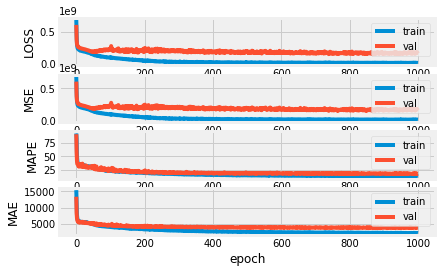

In [30]:
_, train_mse, train_mape, train_mae = model.evaluate(X_train_list, ytrain, verbose=0)
_, val_mse, val_mape, val_mae = model.evaluate(X_val_list, ydev, verbose=0)
print('Train MSE: %.3f, Val MSE: %.3f' % (train_mse, val_mse))
print('Train MAPE: %.3f, Val MAPE: %.3f' % (train_mape, val_mape))
print('Train MAE: %.3f, Val MAE: %.3f' % (train_mae, val_mae))
    
predictions = model.predict(X_val_list)
rounded = [round(x[0]) for x in predictions]

fig, axs = plt.subplots(4)
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='val')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('LOSS')
axs[0].legend()

axs[1].plot(history.history['mean_squared_error'], label='train')
axs[1].plot(history.history['val_mean_squared_error'], label='val')
axs[1].set_xlabel('epoch')    
axs[1].set_ylabel('MSE')
axs[1].legend()

axs[2].plot(history.history['mean_absolute_percentage_error'], label='train')
axs[2].plot(history.history['val_mean_absolute_percentage_error'], label='val')
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('MAPE')
axs[2].legend()
    
axs[3].plot(history.history['mean_absolute_error'], label='train')
axs[3].plot(history.history['val_mean_absolute_error'], label='val')
axs[3].set_xlabel('epoch')
axs[3].set_ylabel('MAE')
axs[3].legend()

<b>Saving the model architecture and weights at one place</b>

In [161]:
model.save("4_layered_embedded_model_701515_nocheck.h5")

test_m = load_model("4_layered_embedded_model_701515_nocheck.h5")



<b>saving model architecture and weights separately</b>

In [59]:
# serialize model to JSON
FourLayered_model_json = model.to_json()

with open("4_layered_embedded_model_701515_nocheck.json", "w") as json_file:
    json_file.write(FourLayered_model_json)
    
# serialize weights to HDF5
model.save_weights("4_layered_embedded_model_701515_nocheck_weights.h5")
print("Saved model to disk")





Saved model to disk


<b>Loading the model and compiling </b>

In [60]:
with open('4_layered_embedded_model_701515_nocheck.json', 'r') as json_file:
    json_model = json_file.read()
    json_file.close()

nocheck_model = model_from_json(json_model)

#Load weights into the loaded model 

nocheck_model.load_weights('4_layered_embedded_model_701515_nocheck_weights.h5')

#compile the loaded_model for further use 

nocheck_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse', 'mape', 'mae'])


In [61]:
#testing 2

_, mse, mape, mae = loaded_model.evaluate(X_test_list, ytest)
print('MSE on test data: %2f' %mse)
print('MAPE on test data: %2f' %mape)
print('MAE on test data: %2f' %mae)


7336/7336 [==============================] - 1s 152us/sample - loss: 164326284.6576 - mean_squared_error: 164326288.0000 - mean_absolute_percentage_error: 17.7168 - mean_absolute_error: 3750.1006
MSE on test data: 164326288.000000
MAPE on test data: 17.716814
MAE on test data: 3750.100586


In [71]:
#Aftermath of stats
print("# of unique source airports tested are : " ,(xtest['origin']).nunique())
print("# of unique source aiports in train are: ", (xtrain['origin']).nunique())
print("# of unique destination airports tested are : " ,(xtest['destination']).nunique())
print("# of unique destination aiports in train are: ", (xtrain['destination']).nunique())

air_dict = {}
#print(len(xtest))
for i in (xtest['origin']).unique():
    for j in (xtest['destination']).unique():
        air_dict.update({i:
                         [j, len(xtest[(xtest['origin'] == i) & (xtest['destination'] == j)]), \
                             len(xtrain[(xtrain['origin'] == i) & (xtrain['destination'] == j)])]\
                                 })
    

df_air = pd.DataFrame.from_dict(air_dict, orient = 'index',  columns=['Destination', 'Test', 'Train']).reset_index()

df_air.columns = ['Source', 'Destination','Test', 'Train']

df_air.to_csv('airport_test_train.csv')

# of unique source airports tested are :  184
# of unique source aiports in train are:  234
# of unique destination airports tested are :  373
# of unique destination aiports in train are:  577


In [89]:
adict = {}
#print(len(xtest))
for i in (xtest['origin']).unique():
    for j in (xtest['destination']).unique():
        count = len(xtest[(xtest['origin'] == i) & (xtest['destination'] == j)]) 
        if (count > 0):
            adict[i, j]=[count, len(xtrain[(xtrain['origin'] ==i)&(xtrain['destination'] ==j)])] 
    


In [95]:
df_air = pd.DataFrame.from_dict(adict,\
                                orient = 'index',  columns=[ 'Test', 'Train']).reset_index()


In [96]:
df_air.to_csv('airport_test_train.csv')

In [64]:
preds = loaded_model.predict(X_test_list)
round_predictions = [round(x[0]) for x in preds]

xtest['predictions_50'] = round_predictions

xtest['Target price'] = ytest

xtest.to_csv('output_50K_withcallback.csv')

In [ ]:
#saving train data 

xtrain.to_csv('Train_data_used_18_val_MAE.csv')

<b>Do not use the further code</b>

<b>Evaluate model on the test data</b>

In [101]:
#preprocess test data and evaluate 
#test_file = 'test_data_after_20181105.csv'
"""
test_file = 'test_data_10K.csv'
model = loaded_model

test_df = load_data_and_preprocess(test_file)
ytest = test_df['min_price']
xtest = test_df.drop(['min_price'],  axis = 1)
print(type(xtest))
#X_train_list, X_test_list = preproc(xtrain, xtest)
_, mse, mape, mae = model.evaluate(X_test_list, ytest)
print('MSE on test data: %2f' %mse)
print('MAPE on test data: %2f' %mape)
print('MAE on test data: %2f' %mae)
predictions = model.predict(X_test_list)
ictions]


xtest['Predictions'] = round_predictions
xtest['Target price'] = ytest


xtest.to_csv('output_test.csv')
"""


<class 'pandas.core.frame.DataFrame'>
9905/9905 [==============================] - 2s 186us/sample - loss: 224104355.5651 - mean_squared_error: 224104432.0000 - mean_absolute_percentage_error: 18.5721 - mean_absolute_error: 4156.3003
MSE on test data: 224104432.000000
MAPE on test data: 18.572096
MAE on test data: 4156.300293


In [44]:
filename = 'data_20.csv'
xdev['Predicted price'] = predictions


xdev['Price'] = ydev

xdev.to_csv('Output' + filename)
type(X_val_list)

xdev.head()

xdev_orig = xdev.reset_index()

In [34]:
#Main call : Stop using 
#This will give me prediction on cross-validation set. from this output we can modify our hyperparameters
"""
def construct_fit_predict(filename, n_epochs , batch_length , verbose_level, optimizer, loss, layers_mat):
    
    start = timeit.default_timer()
    data_df = load_data_and_preprocess(filename)
    [xtrain, xdev, ytrain, ydev] = create_train_val_data(data_df)
    
    model = create_model_and_compile(xtrain, optimizer , loss, layers_mat)
    plot_my_model(model)
    show_model_summary(model)
    
    [X_train_list, X_val_list] = preproc(xtrain, xdev)
    history = model.fit(X_train_list,ytrain , validation_data = (X_val_list, ydev), \
                        epochs =  n_epochs , batch_size = batch_length, verbose= verbose_level)
    
    
    stop = timeit.default_timer()
    
    print("time: %.3f" % (stop-start))
    print("Time taken to train on " +  \
          str(n_epochs) + " epochs with a batch_length of " + str(batch_length) + " is " + str((stop-start)/60) + " minutes" )
   
    fig, axs = plt.subplots(4)
    axs[0].plot(history.history['loss'], label='train')
    axs[0].plot(history.history['val_loss'], label='val')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('LOSS')
    axs[0].legend()

    axs[1].plot(history.history['mean_squared_error'], label='train')
    axs[1].plot(history.history['val_mean_squared_error'], label='val')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('MSE')
    axs[1].legend()

    axs[2].plot(history.history['mean_absolute_percentage_error'], label='train')
    axs[2].plot(history.history['val_mean_absolute_percentage_error'], label='val')
    axs[2].set_xlabel('epoch')
    axs[2].set_ylabel('MAPE')
    axs[2].legend()
    
    axs[3].plot(history.history['mean_absolute_error'], label='train')
    axs[3].plot(history.history['val_mean_absolute_error'], label='val')
    axs[3].set_xlabel('epoch')
    axs[3].set_ylabel('MAE')
    axs[3].legend()
    
    
    _, train_mse, train_mape, train_mae = model.evaluate(X_train_list, ytrain, verbose=0)
    _, val_mse, val_mape, val_mae = model.evaluate(X_val_list, ydev, verbose=0)
    print('Train MSE: %.3f, Val MSE: %.3f' % (train_mse, val_mse))
    print('Train MAPE: %.3f, Val MAPE: %.3f' % (train_mape, val_mape))
    print('Train MAE: %.3f, Val MAE: %.3f' % (train_mae, val_mae))
    
    predictions = model.predict(X_val_list)
    rounded = [round(x[0]) for x in predictions]

    #checking on validation data
    #_,mse,mape c= model.evaluate(X_val_list, ydev)

#    print('MSE on validation data: %2f' %mse)
 #   print('MAPE on validation data: %2f' %mape)
    
    return model, xtrain, history
    
    
"""    

In [ ]:
#stop using 
#model, xtrain, history = construct_fit_predict('data_20.csv', n_epochs = 1000, batch_length = 512, verbose_level = 2, optimizer = 'Adam',\
 #                    loss = 'mean_squared_error', layers_mat = layer_dim)

In [70]:
evaluate_test('test_data_after_20181105.csv', xtrain, loaded_model)

<class 'pandas.core.frame.DataFrame'>
9891/9891 [==============================] - 1s 140us/sample - loss: 6371930437.9076 - mean_squared_error: 6371931648.0000 - mean_absolute_percentage_error: 423.7919 - mean_absolute_error: 42648.2031
MSE on test data: 6371931648.000000
MAPE on test data: 423.791901
MAE on test data: 42648.203125


[42022.0,
 69703.0,
 177939.0,
 31559.0,
 25725.0,
 13026.0,
 21331.0,
 53049.0,
 18746.0,
 22560.0,
 37605.0,
 45192.0,
 87875.0,
 16080.0,
 61021.0,
 62911.0,
 43047.0,
 46365.0,
 90697.0,
 54680.0,
 30533.0,
 84218.0,
 46036.0,
 65994.0,
 43615.0,
 25568.0,
 112355.0,
 39534.0,
 44712.0,
 94673.0,
 55444.0,
 22907.0,
 38885.0,
 55705.0,
 40837.0,
 28007.0,
 46716.0,
 50343.0,
 36271.0,
 18547.0,
 27059.0,
 9980.0,
 35960.0,
 66812.0,
 42870.0,
 23194.0,
 44604.0,
 43394.0,
 13555.0,
 43457.0,
 49843.0,
 29832.0,
 19018.0,
 26816.0,
 26213.0,
 58560.0,
 52966.0,
 72042.0,
 8706.0,
 12363.0,
 126021.0,
 82644.0,
 140569.0,
 56646.0,
 68960.0,
 56418.0,
 30898.0,
 35292.0,
 57725.0,
 80062.0,
 36293.0,
 38468.0,
 28323.0,
 14536.0,
 74535.0,
 38860.0,
 12568.0,
 32631.0,
 27315.0,
 40279.0,
 7590.0,
 27710.0,
 32609.0,
 78092.0,
 47116.0,
 64207.0,
 70003.0,
 68241.0,
 86975.0,
 11752.0,
 32214.0,
 49173.0,
 57023.0,
 53988.0,
 34868.0,
 17437.0,
 56083.0,
 58716.0,
 36983.0,
 48305.0,

In [45]:

xdev_present = np.append((np.array(X_val_list[0:8]).T), np.array(X_val_list[8]), axis =1)

#X_val_list[8]

xdev_present



array([[ 12., 163.,   1., ...,   0.,  73.,  75.],
       [  4., 539.,   3., ...,   0.,  15.,  27.],
       [ 12., 131.,   0., ...,   0.,  80.,  96.],
       ...,
       [ 14., 698.,   2., ...,   0.,  89.,  95.],
       [ 20., 362.,   5., ...,   0.,  65.,  65.],
       [  9., 292.,   1., ...,   0.,  31.,  45.]])

In [46]:
for i in range(5):
    #print('%s,  %d (expected %d)' % \
     #     (np.append((np.array(X_val_list[0:6]).T), np.array(X_val_list[6]), axis =1)[i], predictions[i], ydev[i]))
    
    
    print ("input = " ,xdev_present.tolist()[i])
    print("input_orig = ", xdev.iloc[i])
    print("prediction price = ", predictions[i])
    print("expected price = ", ydev.tolist()[i])
    print("_"*100)


input =  [12.0, 163.0, 1.0, 6.0, 0.0, 0.0, 0.0, 0.0, 73.0, 75.0]
input_orig =  origin                  NUE 
destination             BRU 
DTD                       73
DTR                       75
DoW_D                 Monday
DoW_R              Wednesday
Weekend_D                  N
Indian_Hol_D               N
Weekend_R                  N
Indian_Hol_R               N
Predicted price      9619.32
Price                13239.5
Name: 18391, dtype: object
prediction price =  [9619.315]
expected price =  13239.5
____________________________________________________________________________________________________
input =  [4.0, 539.0, 3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 15.0, 27.0]
input_orig =  origin               FAR 
destination          JNB 
DTD                    15
DTR                    27
DoW_D              Sunday
DoW_R              Friday
Weekend_D               Y
Indian_Hol_D            N
Weekend_R               N
Indian_Hol_R            N
Predicted price    121616
Price              10434

In [47]:
_ , mse, mape = model.evaluate(X_val_list, ydev)

#print(len(model.evaluate(X_val_list, ydev)))
print('MSE on val data: %.2f' %mse)

4998/4998 [==============================] - 1s 112us/sample - loss: 0.2359 - mean_squared_error: 2881656320.0000 - mean_absolute_percentage_error: 34.3044
MSE on val data: 2881656320.00


In [ ]:
#Test data. Just make sure test data comes from the same distribution as train data 

test = pd.read_csv('')